In [62]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [63]:
df = pd.read_csv('../Datasets/temperature (1).csv')
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [64]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

df['Date'] = df.apply(parse_date, axis=1)
auckland = df[df['City']=='Auckland'].copy().dropna()
stockholm = df[df['City']=='Stockholm'].copy().dropna()

In [65]:
###########  Keep only columns we want ##############
auckland = auckland[['Date','AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date','AverageTemperatureFahr']].copy()


###########  set index to date col
auckland.set_index(auckland['Date'],inplace=True)
auckland.drop('Date',axis=1,inplace=True)
auckland.columns = ['AucklandTemp']

In [66]:
stockholm.set_index(stockholm['Date'],inplace=True)
stockholm.drop('Date',axis=1,inplace=True)
stockholm.columns = ['StockholmTemp']

In [67]:
joined = auckland.join(stockholm,how='outer')  ## has some missing data
joined.shape

(3155, 2)

<Axes: xlabel='Date'>

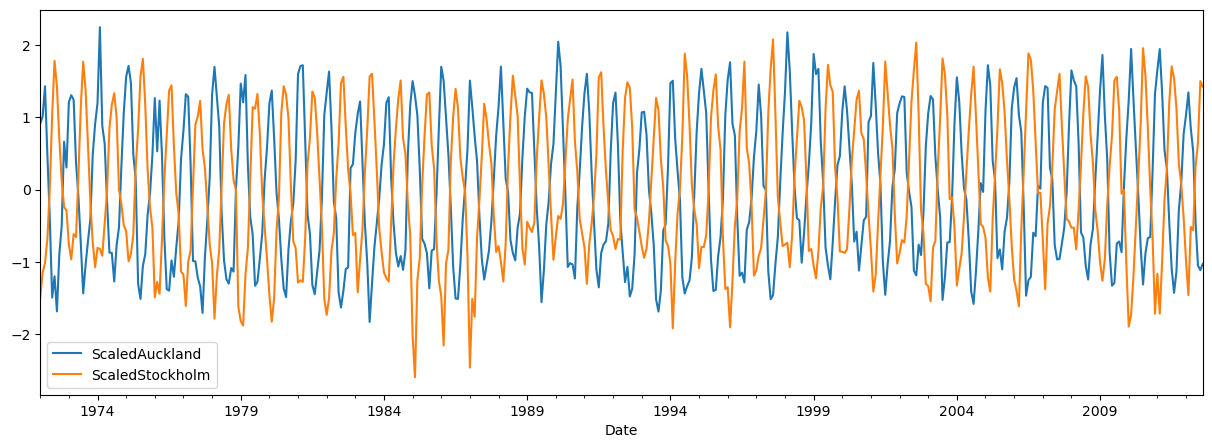

In [70]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'
joined_part.interpolate(inplace=True)  #### handle missing values 


Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

scalar_auckland = StandardScaler()
train['ScaledAuckland'] = scalar_auckland.fit_transform(train[['AucklandTemp']])
test['ScaledAuckland'] = scalar_auckland.transform(test[['AucklandTemp']])


scalar_stockholm = StandardScaler()
train['ScaledStockholm'] = scalar_stockholm.fit_transform(train[['StockholmTemp']])
test['ScaledStockholm'] = scalar_stockholm.transform(test[['StockholmTemp']])


train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]



###### put them back in the original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = train['ScaledStockholm']

cols = ['ScaledAuckland','ScaledStockholm']
train[cols].plot(figsize=(15,5))


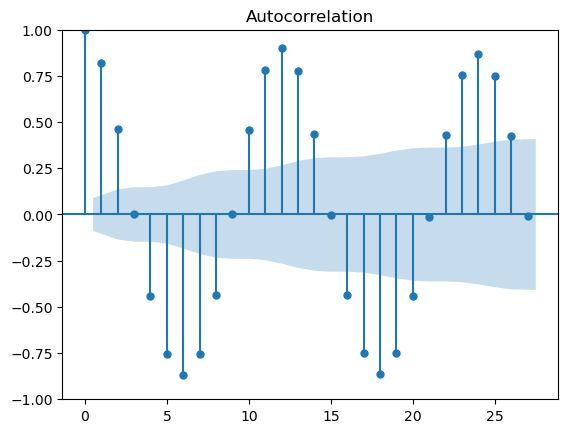

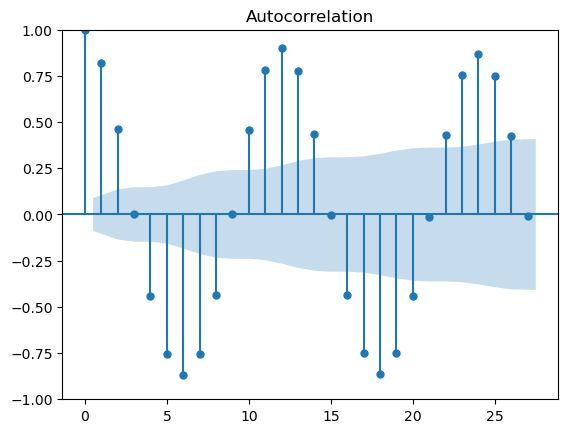

In [71]:
plot_acf(train['ScaledAuckland'])

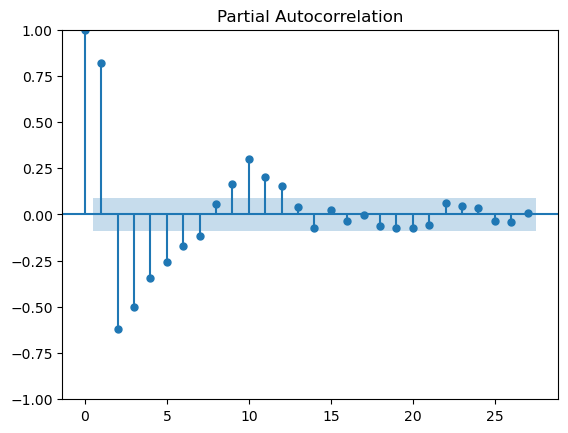

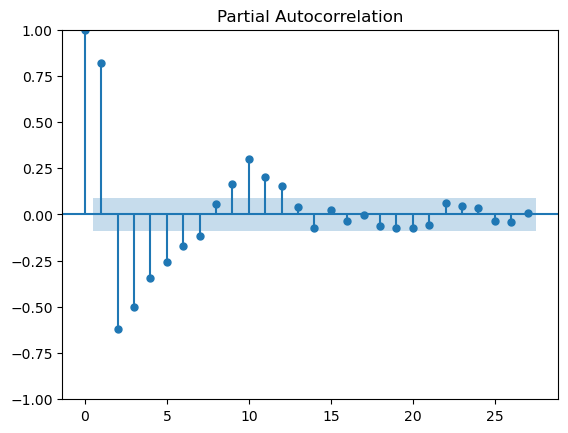

In [72]:
plot_pacf(train['ScaledAuckland'])

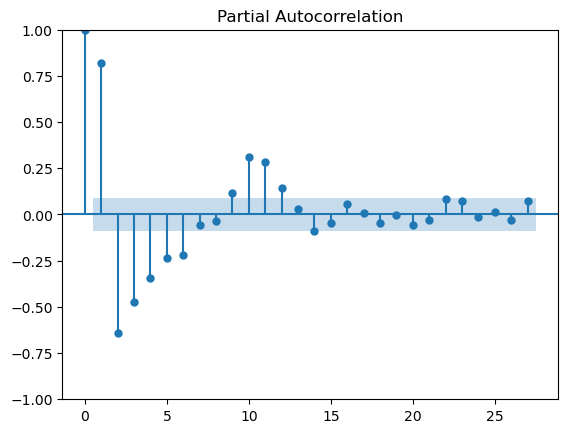

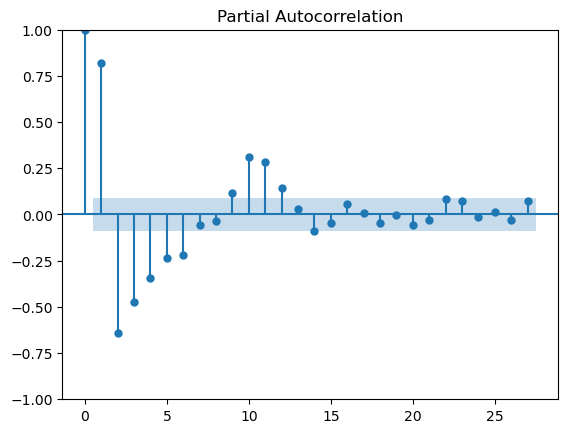

In [74]:
plot_pacf(train['ScaledStockholm'])

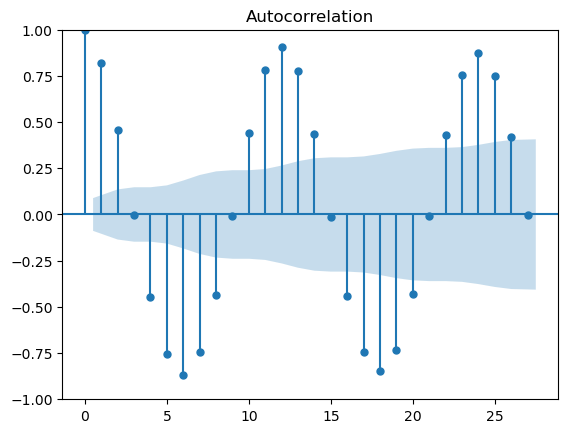

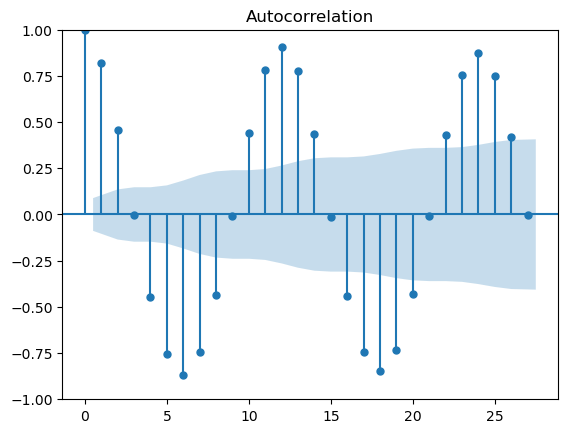

In [75]:
plot_acf(train['ScaledStockholm'])

In [76]:
t0 = datetime.now()
model = VARMAX(train[cols],order=(10,10))
res = model.fit(maxiter=100)
print(datetime.now()- t0)

c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Tharindu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0:02:39.769324


In [77]:
fcast = res.get_forecast(Ntest)

In [78]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.012604
1972-02-01    0.821684
1972-03-01    0.713159
1972-04-01    0.809371
1972-05-01   -0.082923
                ...   
2012-04-01    0.520688
2012-05-01   -0.298183
2012-06-01   -1.071482
2012-07-01   -1.340781
2012-08-01   -1.067371
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

<Axes: xlabel='Date'>

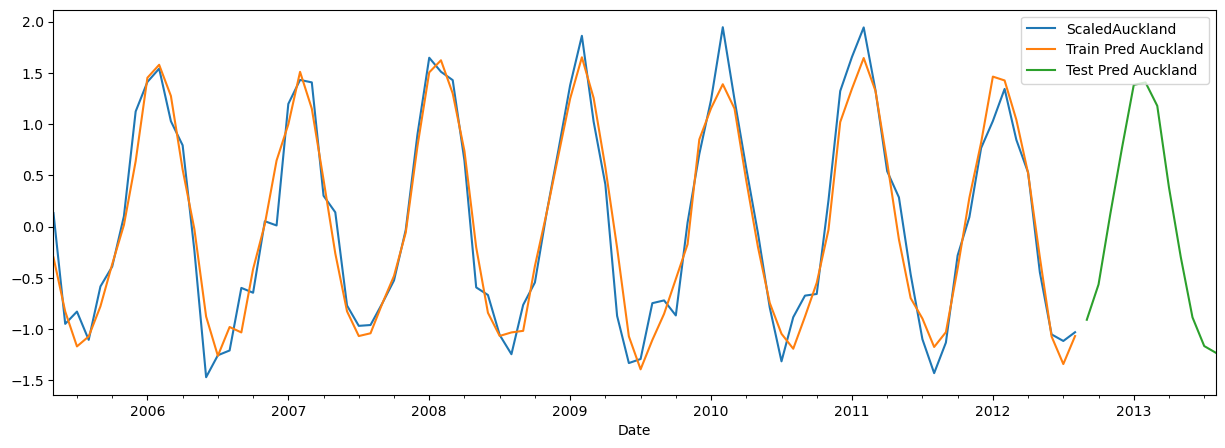

In [79]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx,'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

plot_cols = ['ScaledAuckland','Train Pred Auckland','Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5))

<Axes: xlabel='Date'>

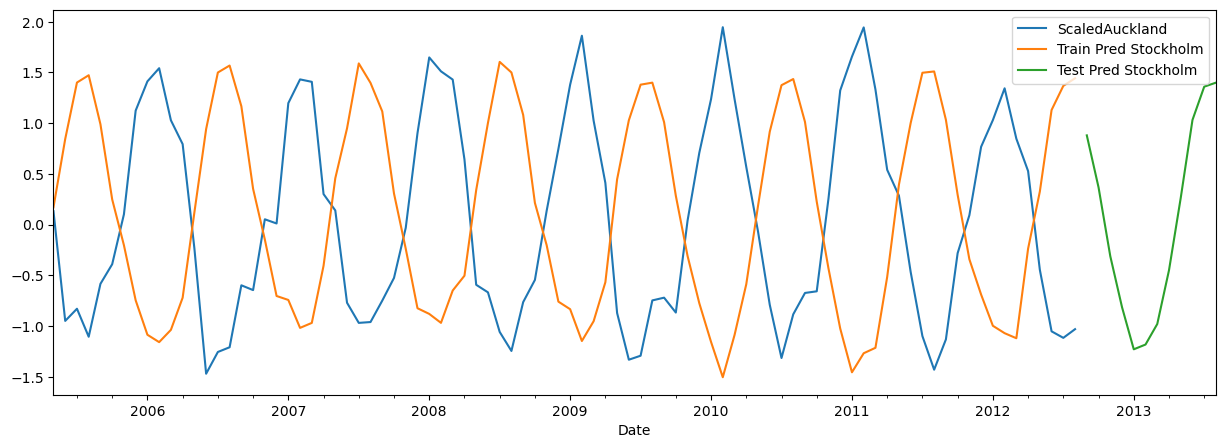

In [80]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx,'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

plot_cols = ['ScaledAuckland','Train Pred Stockholm','Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5))